In [1]:
from fastbook import *

In [2]:
urls = search_images_ddg('teddy photos', max_images=1)
len(urls), urls[0]

(1, 'https://cdn.wallpapersafari.com/88/17/CHu6KA.jpg')

In [11]:
dest = Path('teddy.jpg')
if not dest.exists(): download_url(urls[0], dest)

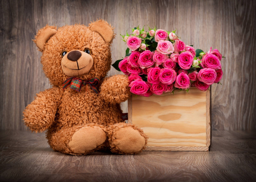

In [12]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [44]:
import requests

In [52]:
bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')

if not path.exists():
    path.mkdir()

for o in bear_types:
    dest = path / o
    dest.mkdir(exist_ok=True)
    
    # Search for images
    results = search_images_ddg(f'{o} bear', max_images=5)
    
    # Debugging: Check the results
    if results is None:
        print(f"No results for {o} bear")
        continue
    
    print(f"Results for {o} bear: {results}")
    print(f"Saving images to: {dest}")
    
    for i in range(len(results)):
        url = results[i]  # Assuming results contain URLs

        # Verify URL is an image
        response = requests.head(url, allow_redirects=True)
        content_type = response.headers.get('Content-Type')
        
        dest2 = dest / f"{i}.jpg"  # Save files with .jpg extension
        print(f"Downloading {url} to {dest2}")
        if 'image' not in content_type:
            print(f"Skipping non-image URL: {url}")
            continue
        
        try:
            download_url(url, dest2)
        except Exception as e:
            print(f"Failed to download {url}: {e}")

Results for grizzly bear: ['http://snowbrains.com/wp-content/uploads/2016/06/outdoorhub-yellowstone-grizzly-bear-kills-hiker-in-apparent-predatory-attack-2015-08-12_15-18-35.jpg', 'http://images2.fanpop.com/image/photos/13100000/Grizzly-Bears-animals-13128575-1024-768.jpg', 'https://www.expeditionsalaska.com/wp-content/uploads/2017/01/12_mar6100.jpg', 'https://mediaproxy.salon.com/width/1200/https://media.salon.com/2014/03/Grizzly-Bear.jpg', 'https://wallup.net/wp-content/uploads/2016/01/30094-bears-nature-animals-Grizzly_bear-Grizzly_Bears.jpg']
Saving images to: bears/grizzly
Failed to download http://snowbrains.com/wp-content/uploads/2016/06/outdoorhub-yellowstone-grizzly-bear-kills-hiker-in-apparent-predatory-attack-2015-08-12_15-18-35.jpg: argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'L'
Failed to download http://images2.fanpop.com/image/photos/13100000/Grizzly-Bears-animals-13128575-1024-768.jpg: argument should be a str or an os.PathLike 

In [62]:
fns = get_image_files(path)
fns

(#13) [Path('bears/black/3.jpg'),Path('bears/black/4.jpg'),Path('bears/black/2.jpg'),Path('bears/teddy/3.jpg'),Path('bears/teddy/4.jpg'),Path('bears/teddy/0.jpg'),Path('bears/teddy/1.jpg'),Path('bears/teddy/2.jpg'),Path('bears/grizzly/3.jpg'),Path('bears/grizzly/4.jpg')...]

In [63]:
failed = verify_images(fns)
failed

(#0) []

In [64]:
failed.map(Path.unlink)

(#0) []

In [86]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.5, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [87]:
dls = bears.dataloaders(path)

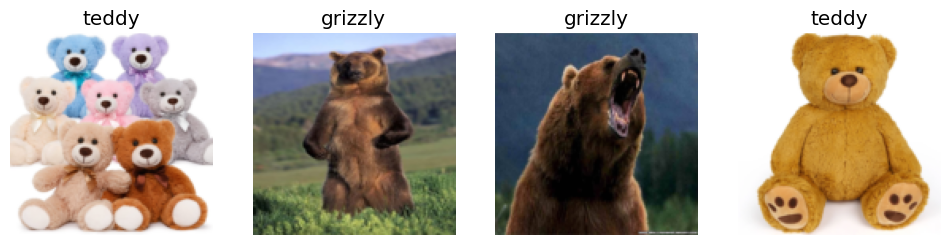

In [93]:
dls.valid.show_batch(max_n=4, nrows=1)

In [89]:
batch = dls.valid.one_batch()
print(len(batch[0]))


6


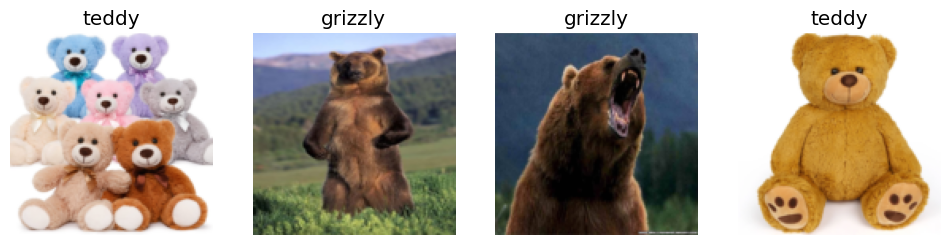

In [90]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)